# CIFAR-10 인식
- MLP와 CNN 성능 비교
- Cifar 10
 - 토론토대학에서 제공하는 이미지 데이터
 - 10종의 클래스에 대해 각 클래스별 5000장의 훈련용 사진과 1000장의 검증용 사진을 제공
 - 총 6만장
- MLP 모델을 이용하면 분류 성능이 50% 이하가 된다
 - MNIST 처럼 데이터가 균일한 모양이 아니므로 MLP로는 한계가 있다
 - 2차원 구조의 이미지를 1차원으로 펴서 보면 공간 정보를 잃게 된다
- 이미지 인식에는 CNN의 성능이 우수하다

# import

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.12.0+cu113  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

# 데이터

In [5]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [6]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


## 데이터 확인


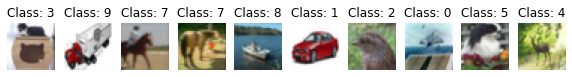

In [7]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

# MLP 모델

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x 

In [10]:
model = Net().to(DEVICE)


print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


## 최적화기, 손실함수 정의

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

## 훈련 함수 정의 (train, evaluate)

In [11]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [12]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 성능 측정

In [12]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.306783
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.913780
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.990749
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.921087
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.882599
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.872453
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.752605
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 2.095602

[EPOCH: 1], 	Test Loss: 1.6877, 	Test Accuracy: 40.22 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.590184
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.446126
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.783406
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 2.052973
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.287844
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.752528
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.401231
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.481704

[EPOCH: 2], 	Test Loss: 1.5852, 	Test Accuracy: 43.81 % 

# CNN 모델

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [14]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


- train, evaluate 함수는 앞에서 정의한 것과 동일하다


## 실행 및 평가

In [15]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.323712
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.159304
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.823718
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.643401
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.559012
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.374510
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 2.029948
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.389879

[EPOCH: 1], 	Test Loss: 1.5592, 	Test Accuracy: 42.43 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.631041
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.462776
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.575070
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.589141
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.471500
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.552527
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.303727
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.286432

[EPOCH: 2], 	Test Loss: 1.3224, 	Test Accuracy: 52.55 % 

# 데이터 증식
- 이미지를 불러올 때 torchvision이 제공하는 transforms의 Compose 함수를 사용
- [데이터 증식 개념](https://towardsdatascience.com/machinex-image-data-augmentation-using-keras-b459ef87cd22)
- [데이터 증식 코드](https://incredible.ai/pytorch/2020/04/25/Pytorch-Image-Augmentation/)

## DataLoader 재정의
- 데이터 증식을 수행하도록 정의해야 한다

In [23]:
# 데이터 증식을 수행
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),  # (0~1)로 정규화
                                    # 3가지 특성(색)에 대해서 평균과 표준편차를 각각 0.5로 적용하는 정규화 수행
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


- CNN, model, optimizer, criterion, train, evaluate 등의 함수는 동일하게 사용한다

## 데이터 증식의 경우 CNN 성능 평가

In [20]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 3.626831
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.852307
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.204331
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.490681
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.501846
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.541755
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.457003
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.654099

[EPOCH: 1], 	Test Loss: 1.1725, 	Test Accuracy: 59.90 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.559812
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.249026
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.484033
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.750396
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.488298
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.301460
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.307488
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.387433

[EPOCH: 2], 	Test Loss: 1.2043, 	Test Accuracy: 58.07 % 

# 다른 모델 사용하기
 - [기존의 다른 모델 보기](https://pytorch.org/vision/stable/models.html)
 - 모델 뿐 아니라 ImageNet 데이터로 미리 학습된 파라미터를 같이 불러올 수 있다
 - 두가지 경우가 있다
  - pretrained=True 로 지정하면 파라미터도 가져온다
  - pretrained=false 로 지정하면 파라미터는 랜덤하게 초기화 한다
 
 - [Resnet34](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8)을 이용하는 예를 소개하겠다

## Resnet34 사용하기
- 데이터 증식을 위한 DataLoader를 수행해야 함

In [24]:
import torchvision.models as models
# model = models.resnet34(pretrained = False)
model = models.resnet34(pretrained = True) # 미리 학습된 모델을 그대로 사용하는 경우 (비교)
num_ftrs = model.fc.in_features     # 모델의 FC 부분의 입력 특성 수 보기 (1000임)
model.fc = nn.Linear(num_ftrs, 10)  # 출력셀의 수가 10개인 전결합망을 만든다
model = model.cuda()                # model.to(DEVICE)와 같은 동작을 한다. 디바이스 배정

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

## 학습 및 성능 평가하기
- train, evaluate, optimizer, criterion은 그대로 사용한다

In [26]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.470791
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.148542
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.181551
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.219691
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.213568
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.279081
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.945188
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.947455

[EPOCH: 1], 	Test Loss: 1.5681, 	Test Accuracy: 50.50 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.362913
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.596097
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.514730
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.831949
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.702970
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.530581
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.939619
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.216301

[EPOCH: 2], 	Test Loss: 0.7759, 	Test Accuracy: 73.80 % 